# Stations network (Winter 2018, weekday)


In [1]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import networkx as nx
import matplotlib.pyplot as plt

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender


In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WD_unique = np.unique(np.concatenate((weekday_subs_trips_df['start station id'].unique(),weekday_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WD_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WD_unique)

[]


True

In [7]:
weekday_subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,505,31956,Subscriber,1992,1,0,0,13,14,26,Daytime Errand,"(72, 505)"
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,3255,32536,Subscriber,1969,1,0,0,15,15,49,Daytime Errand,"(72, 3255)"
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,525,16069,Subscriber,1956,1,0,0,15,15,62,Daytime Errand,"(72, 525)"
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,447,31781,Subscriber,1974,1,0,0,15,15,44,Daytime Errand,"(72, 447)"
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,3356,30319,Subscriber,1992,1,0,0,18,18,26,Commuter,"(72, 3356)"


In [30]:
edge_list_ser = weekday_subs_trips_df.groupby(['pickup_hour','start_end_station']).count()['bikeid']
#edge_list_ser2 = edge_list_ser.reset_index().set_index('start_end_station')#.pivot(columns='pickup_hour').fillna(0)
len(edge_list_ser)

517939

In [40]:
#hourly_df = edge_list_ser2.pivot(columns='pickup_hour').fillna(0)
hourly_sorted_edge_list_lst = []
hourly_G_lst = []
hourly_station_tot_ser_lst = []

hourly_test_lst = []

hourly_num_out_df = weekday_subs_trips_df.groupby(['pickup_hour', 'start station id']).count()['bikeid']
hourly_num_in_df = weekday_subs_trips_df.groupby(['pickup_hour','end station id']).count()['bikeid'] # This is a little weird but I am using pickup hour with end station id to be consistent with the choice of parameterizing triptimes based on when they started

for hour in range(24):
    hourly_sorted_edge_list_lst.append(edge_list_ser.loc[hour].sort_values(ascending=False))
    #hourly_sorted_edge_list_lst.append(hourly_df[hourly_df['bikeid',hour]>0]['bikeid',hour].sort_values(ascending=False))
    curr_edge_list_ser = hourly_sorted_edge_list_lst[hour][:500]
    
    hourly_G_lst.append(nx.Graph())
    curr_G = hourly_G_lst[hour]
    
    w_edge_list = [(i[0],i[1],curr_edge_list_ser[i]) for i in curr_edge_list_ser.index]
    curr_G.add_weighted_edges_from(w_edge_list,weight='num_trips')
    
    tot_ser = hourly_num_out_df.loc[hour] + hourly_num_in_df.loc[hour]
       
    hourly_station_tot_ser_lst.append(tot_ser.fillna(0))


In [41]:
import tilemapbase
tilemapbase.start_logging()

In [42]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [43]:
t = tilemapbase.tiles.Carto_Dark

In [44]:
for hour in range(24):
    G = hourly_G_lst[hour]
    tot_df = hourly_station_tot_ser_lst[hour]
    for node in G.nodes():
        G.nodes[node]['Location']= (stations_info_df.loc[node]['lon'],stations_info_df.loc[node]['lat'])
        G.nodes[node]['TMB_loc']= tilemapbase.project(nx.get_node_attributes(G,'Location')[node][0],nx.get_node_attributes(G,'Location')[node][1])
        G.nodes[node]['usage']= tot_df.loc[node]


In [ ]:
btwn_centrality_ser = pd.Series(nx.betweenness_centrality(G,normalized=True, endpoints=False))
close_centrality_ser = pd.Series(nx.closeness_centrality(G,wf_improved=True))

## Degree as node color

the degree node v is the number of edges connected to it

In [36]:
def plot_station_network(G,hour = None):
    fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    node_color = [G.degree(v) for v in G]
    #node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
    #node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
    node_size = [0.01*nx.get_node_attributes(G, 'usage')[v] for v in G]
    #pos = nx.get_node_attributes(G,'Location')
    pos=nx.get_node_attributes(G,'TMB_loc')
    edge_width = [0.01*G[u][v]['num_trips'] for u,v in G.edges()]
    
    nx.draw_networkx(G, pos, node_size=node_size, 
                     node_color=node_color, alpha=.7, with_labels=False, 
                     width=edge_width, #edge_color='.4', 
                     cmap=plt.cm.cool,
                     vmin=sorted(node_color)[0],
                     vmax = sorted(node_color)[-1],
                     edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                     edge_cmap = plt.cm.autumn_r,
                     edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])
    
    if hour != None:
        if hour == 0:
            title = '{} AM'.format(hour + 12)
        elif hour < 12:
            title = '{} AM'.format(hour)
        elif hour == 12:
            title = '{} PM'.format(hour)
        elif hour < 24:
            title = '{} PM'.format(hour - 12)
            
    ax.set_title(title)
    
    
    plt.axis('off')
    plt.tight_layout();

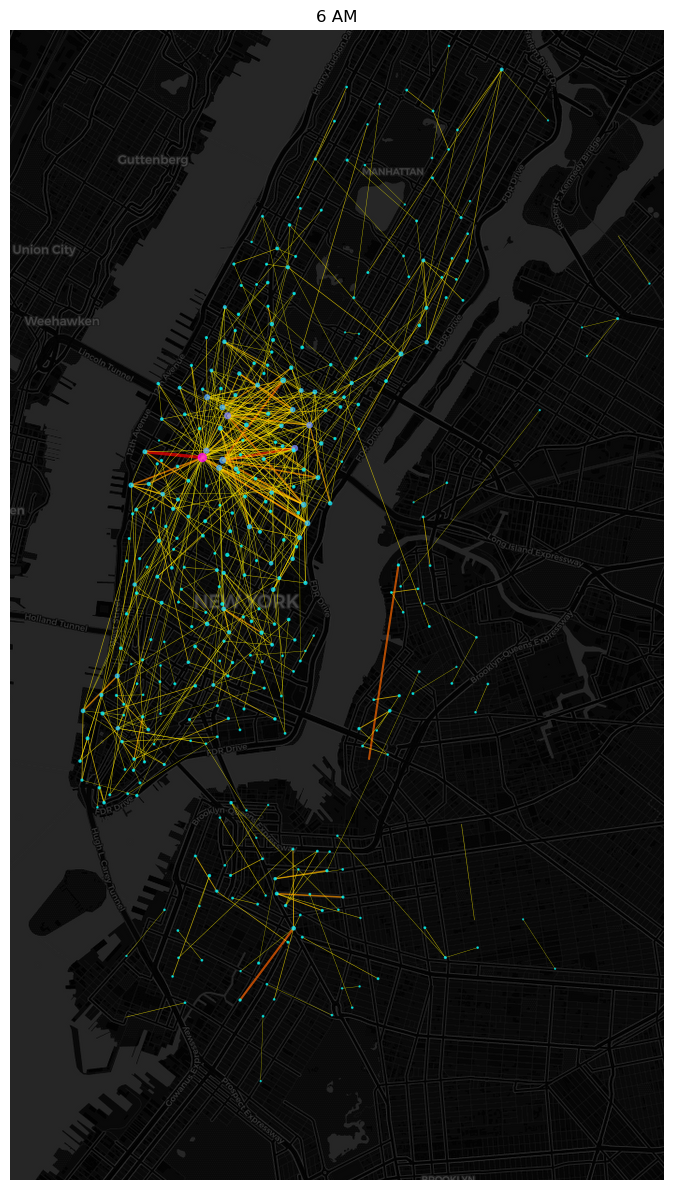

In [45]:
plot_station_network(hourly_G_lst[6],6)# Rush hour morning

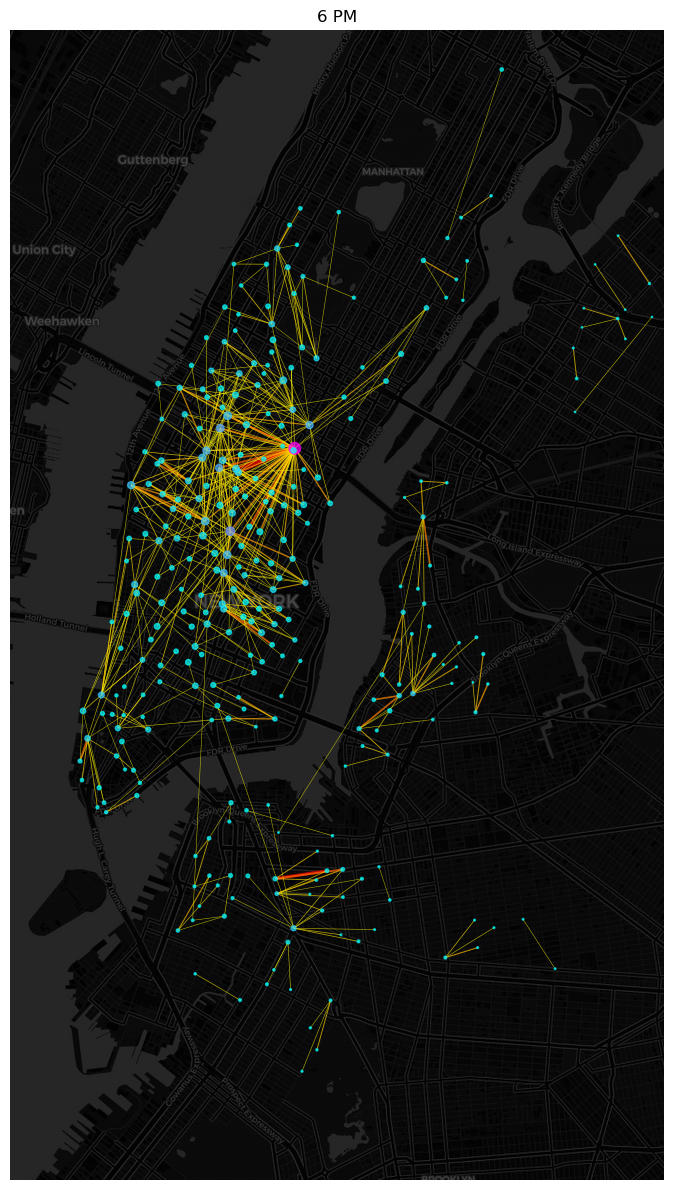

In [46]:
plot_station_network(hourly_G_lst[18],18)# Rush hour evening

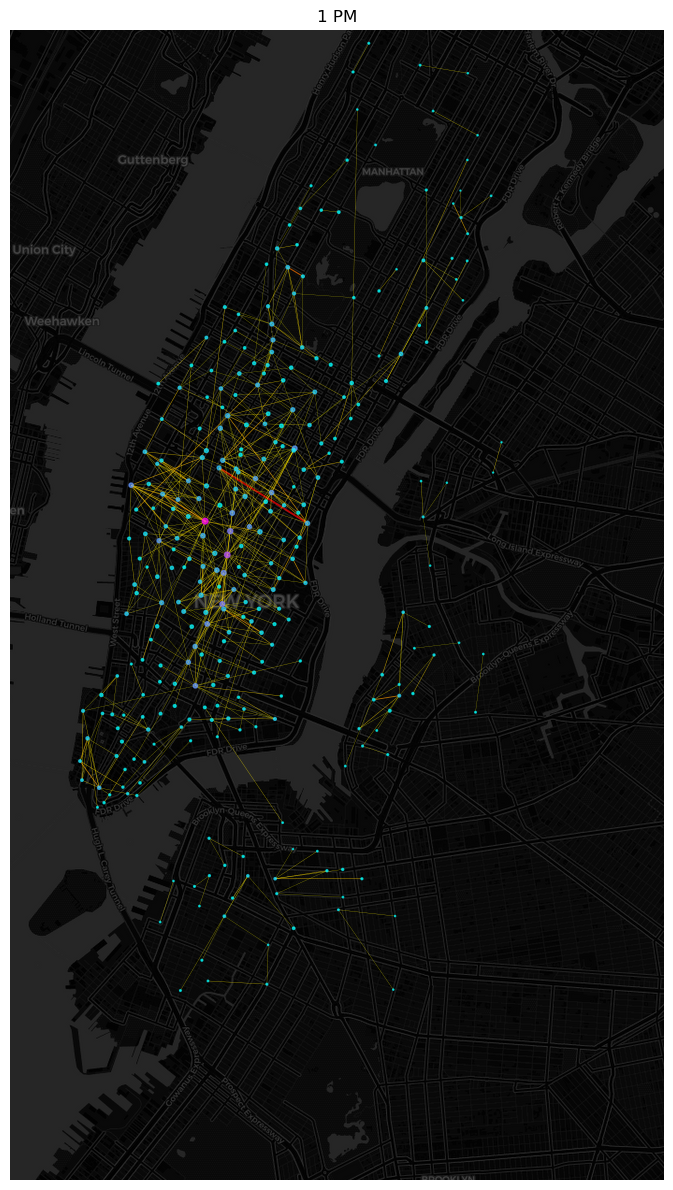

In [47]:
plot_station_network(hourly_G_lst[13],13)# Lunchtime

In [128]:
for hour in range(24):
    plot_station_network(hourly_G_lst[hour],hour)
    
    plt.savefig('../Images/Winter_2018/Winter_2018_WD_trips_{}.png'.format(str(hour)));
    plt.close()


In [129]:
from PIL import Image

hourly_ims = []

for hour in range(24):
    im = Image.open('../Images/Winter_2018/Winter_2018_WD_trips_{}.png'.format(str(hour)))
    hourly_ims.append(im)
    
hourly_ims[0].save('../Images/Winter_2018/Winter_2018_WD_trips.gif',
               save_all=True,
               append_images=hourly_ims[1:],
               duration=600,
               loop=0)